# CV - Transfer Learning & Fine Tuning - Mini Project

## Dataset : Rock-Paper-Scissors

## Pretrained Models:  MobileNetv2 ,  Xception

### Importing Libraries

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf

import zipfile
import os

## Downloading the dataset

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
zip_path = "/content/drive/MyDrive/Dataset/Rock Paper Scissors Dataset/archive.zip"

In [4]:
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall("/content/archive")

In [5]:
os.listdir("/content/archive")

['Rock-Paper-Scissors', 'rock-paper-scissors']

In [6]:
for dirpath, dirnames, filenames in os.walk("archive"):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

There are 2 directories and 0 images in 'archive'.
There are 3 directories and 0 images in 'archive/Rock-Paper-Scissors'.
There are 0 directories and 33 images in 'archive/Rock-Paper-Scissors/validation'.
There are 3 directories and 0 images in 'archive/Rock-Paper-Scissors/train'.
There are 0 directories and 840 images in 'archive/Rock-Paper-Scissors/train/scissors'.
There are 0 directories and 840 images in 'archive/Rock-Paper-Scissors/train/rock'.
There are 0 directories and 840 images in 'archive/Rock-Paper-Scissors/train/paper'.
There are 3 directories and 0 images in 'archive/Rock-Paper-Scissors/test'.
There are 0 directories and 124 images in 'archive/Rock-Paper-Scissors/test/scissors'.
There are 0 directories and 124 images in 'archive/Rock-Paper-Scissors/test/rock'.
There are 0 directories and 124 images in 'archive/Rock-Paper-Scissors/test/paper'.
There are 1 directories and 0 images in 'archive/rock-paper-scissors'.
There are 3 directories and 0 images in 'archive/rock-paper-

## Creating data loaders

In [7]:
PATH = 'archive'

train_dir = os.path.join(PATH, 'Rock-Paper-Scissors/train')
test_dir = os.path.join(PATH, 'Rock-Paper-Scissors/test')

BATCH_SIZE = 32
IMG_SIZE = (224, 224)

train_dataset = tf.keras.utils.image_dataset_from_directory(train_dir,
                                                            shuffle=True,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE)

validation_dataset = tf.keras.utils.image_dataset_from_directory(test_dir,
                                                                 shuffle=True,
                                                                 batch_size=BATCH_SIZE,
                                                                 image_size=IMG_SIZE)

Found 2520 files belonging to 3 classes.
Found 372 files belonging to 3 classes.


In [8]:
for images, labels in train_dataset.take(1):
    print(f"Images shape: {images.shape}")
    print(f"Labels shape: {labels.shape}")
    print(f"Labels: {labels.numpy()}")

Images shape: (32, 224, 224, 3)
Labels shape: (32,)
Labels: [0 2 0 2 2 1 0 0 2 0 1 1 1 0 1 0 2 0 0 0 1 2 2 2 2 1 1 0 2 1 0 1]


In [9]:
class_names = train_dataset.class_names
print(class_names)

['paper', 'rock', 'scissors']


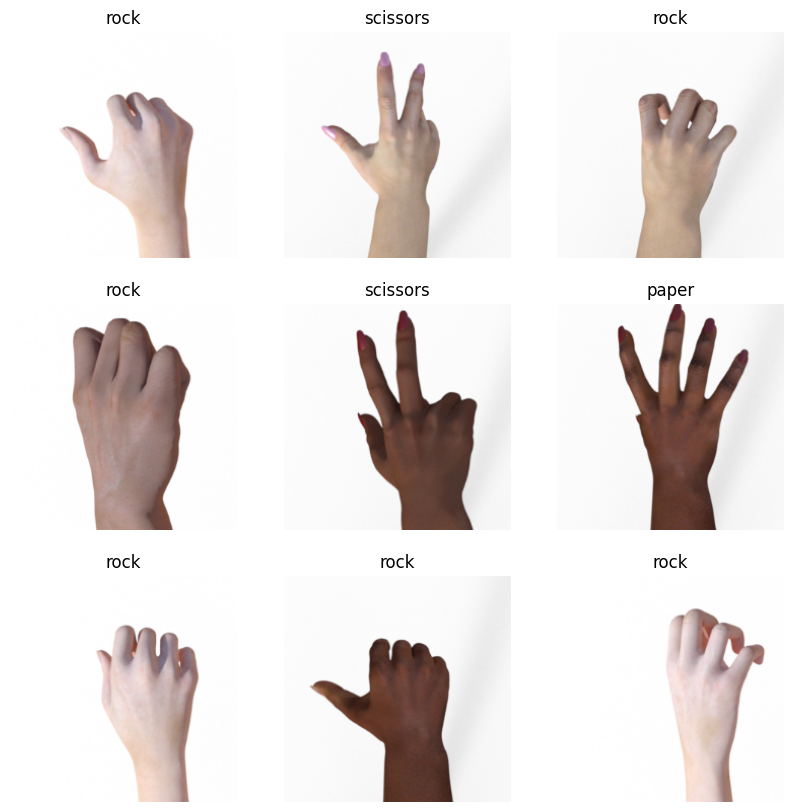

In [10]:
plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

# Creating test and validation sets

In [11]:
val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(4* val_batches // 5)
validation_dataset = validation_dataset.skip(4* val_batches // 5)

In [12]:
print('Number of train batches: %d' % tf.data.experimental.cardinality(train_dataset))
print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Number of train batches: 79
Number of validation batches: 3
Number of test batches: 9


## Prefecting Data Pipeline

In [13]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

## Loading the Pretrained Model : MobileNetV2

In [ ]:
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

In [ ]:
base_model.trainable = False

In [ ]:
base_model.summary()

Model: "mobilenetv2_1.00_224"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,257,984 (8.61 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 2,257,984 (8.61 MB)

## Adding custom top to the base model - MobileNetV2

In [ ]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 7, 7, 1280)


In [ ]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()

feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


In [ ]:
prediction_layer = tf.keras.layers.Dense(3, activation='softmax')

prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 3)


In [ ]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.2),
])

In [ ]:
dropout_layer = tf.keras.layers.Dropout(0.2)

In [ ]:
inputs = tf.keras.Input(shape=(224, 224, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = dropout_layer(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [ ]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ true_divide (TrueDivide)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ subtract (Subtract)             │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 3)              │         3,843 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,261,827 (8.63 MB)

 Trainable params: 3,843 (15.01 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [ ]:
len(model.trainable_variables)

2

## Train the model - MobileNetV2

In [ ]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=["accuracy"])

In [ ]:
loss0, accuracy0 = model.evaluate(validation_dataset)

3/3 ━━━━━━━━━━━━━━━━━━━━ 5s 272ms/step - accuracy: 0.3424 - loss: 1.9028


In [ ]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                                                 factor=0.5,
                                                 patience=3,
                                                 min_lr=1e-6,
                                                 verbose=1)
checkpoint = tf.keras.callbacks.ModelCheckpoint('best_tuned_model.keras',
                                                monitor='val_loss',
                                                save_best_only=True,
                                                verbose=1)
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                              patience=10,
                                              restore_best_weights=True,
                                              verbose=1)

In [ ]:
initial_epochs = 100

history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset,
                    callbacks=[reduce_lr, checkpoint, early_stop])

Epoch 1/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 0.4358 - loss: 1.2023
Epoch 1: val_loss improved from inf to 0.97851, saving model to best_tuned_model.keras
79/79 ━━━━━━━━━━━━━━━━━━━━ 15s 93ms/step - accuracy: 0.4367 - loss: 1.2002 - val_accuracy: 0.4524 - val_loss: 0.9785 - learning_rate: 1.0000e-04
Epoch 2/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 0.6888 - loss: 0.7723
Epoch 2: val_loss improved from 0.97851 to 0.93566, saving model to best_tuned_model.keras
79/79 ━━━━━━━━━━━━━━━━━━━━ 8s 101ms/step - accuracy: 0.6893 - loss: 0.7715 - val_accuracy: 0.4762 - val_loss: 0.9357 - learning_rate: 1.0000e-04
Epoch 3/100
78/79 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 0.8034 - loss: 0.5695
Epoch 3: val_loss improved from 0.93566 to 0.92312, saving model to best_tuned_model.keras
79/79 ━━━━━━━━━━━━━━━━━━━━ 7s 82ms/step - accuracy: 0.8040 - loss: 0.5687 - val_accuracy: 0.4762 - val_loss: 0.9231 - learning_rate: 1.0000e-04
Epoch 4/100
78/79 ━━━━━━━━━━━━━━━━━━━━ 

In [ ]:
loss1, accuracy1 = model.evaluate(test_dataset)
loss2, accuracy2 = model.evaluate(train_dataset)
print('Test loss :', loss1)
print('Train loss :', loss2)
print('Test accuracy :', accuracy1)
print('Train accuracy :', accuracy2)

9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - accuracy: 0.7985 - loss: 0.4369
79/79 ━━━━━━━━━━━━━━━━━━━━ 6s 79ms/step - accuracy: 0.9902 - loss: 0.0952
Test loss : 0.46303632855415344
Train loss : 0.09444018453359604
Test accuracy : 0.7916666865348816
Train accuracy : 0.9888888597488403


In [ ]:
history_df = pd.DataFrame(history.history)

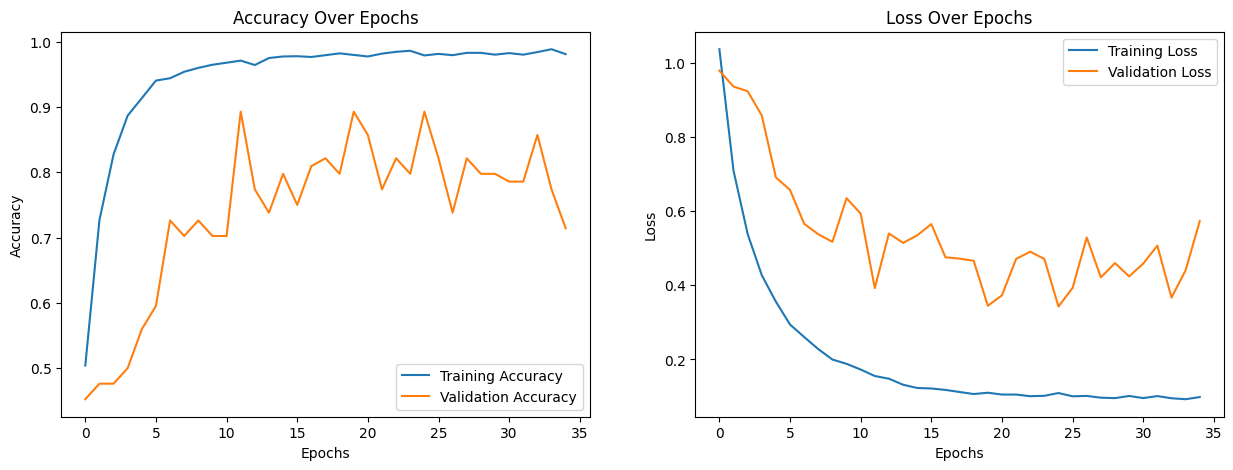

In [ ]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(history_df['accuracy'], label='Training Accuracy')
plt.plot(history_df['val_accuracy'], label='Validation Accuracy')
plt.title("Accuracy Over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_df['loss'], label='Training Loss')
plt.plot(history_df['val_loss'], label='Validation Loss')
plt.title("Loss Over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [ ]:
from sklearn.metrics import confusion_matrix

y_true = []
y_pred = []
for images, labels in test_dataset:
    preds = model.predict(images, verbose=0)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(preds, axis=1))

cm = confusion_matrix(y_true, y_pred)

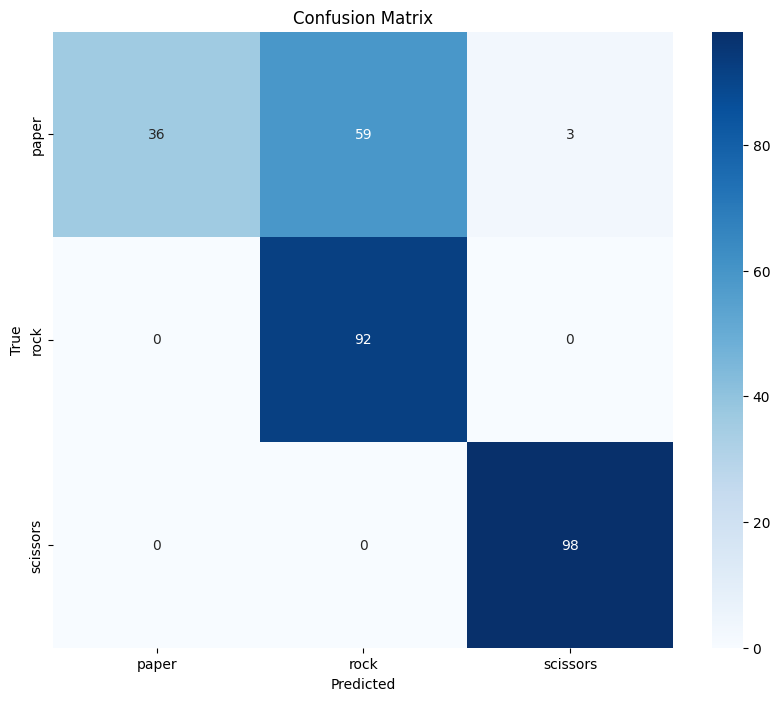

In [ ]:
# Plot
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Fine Tuning the Model - MobileNetV2

In [ ]:
print("Number of layers in the base model: ", len(base_model.layers))

Number of layers in the base model:  154


In [ ]:
base_model.trainable = True

In [ ]:
fine_tune_at = 120

for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

In [ ]:
len(model.trainable_variables)

38

In [ ]:
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              optimizer = tf.keras.optimizers.Adam(learning_rate=base_learning_rate/10),
              metrics=["accuracy"])

In [ ]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ true_divide (TrueDivide)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ subtract (Subtract)             │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 3)              │         3,843 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,261,827 (8.63 MB)

 Trainable params: 1,628,739 (6.21 MB)

 Non-trainable params: 633,088 (2.42 MB)

In [ ]:
fine_tune_epochs = 100
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=len(history.epoch),
                         validation_data=validation_dataset,
                         callbacks=[reduce_lr, checkpoint, early_stop])

Epoch 36/200
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - accuracy: 0.9026 - loss: 0.2652
Epoch 36: val_loss did not improve from 0.34295
79/79 ━━━━━━━━━━━━━━━━━━━━ 30s 215ms/step - accuracy: 0.9030 - loss: 0.2644 - val_accuracy: 0.7857 - val_loss: 0.4987 - learning_rate: 1.0000e-05
Epoch 37/200
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step - accuracy: 0.9801 - loss: 0.0848
Epoch 37: val_loss did not improve from 0.34295
79/79 ━━━━━━━━━━━━━━━━━━━━ 14s 180ms/step - accuracy: 0.9801 - loss: 0.0846 - val_accuracy: 0.8333 - val_loss: 0.4098 - learning_rate: 1.0000e-05
Epoch 38/200
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - accuracy: 0.9865 - loss: 0.0501
Epoch 38: val_loss did not improve from 0.34295
79/79 ━━━━━━━━━━━━━━━━━━━━ 18s 152ms/step - accuracy: 0.9865 - loss: 0.0501 - val_accuracy: 0.8571 - val_loss: 0.3695 - learning_rate: 1.0000e-05
Epoch 39/200
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step - accuracy: 0.9946 - loss: 0.0338
Epoch 39: val_loss did not improve from 0.34295
79/79 ━━━━━━━━━━━━━

In [ ]:
loss3, accuracy3 = model.evaluate(test_dataset)
loss4, accuracy4 = model.evaluate(train_dataset)
print('Test loss :', loss3)
print('Train loss :', loss4)
print('Test accuracy :', accuracy3)
print('Train accuracy :', accuracy4)

9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 123ms/step - accuracy: 0.8761 - loss: 0.3606
79/79 ━━━━━━━━━━━━━━━━━━━━ 6s 74ms/step - accuracy: 1.0000 - loss: 0.0036
Test loss : 0.3652263283729553
Train loss : 0.0036556939594447613
Test accuracy : 0.875
Train accuracy : 1.0


In [ ]:
history_fine_df = pd.DataFrame(history_fine.history)
history_fine_df.index += len(history_df)

In [ ]:
history_full_df = pd.concat([history_df, history_fine_df])

In [ ]:
finetune_start_epoch = len(history_df)

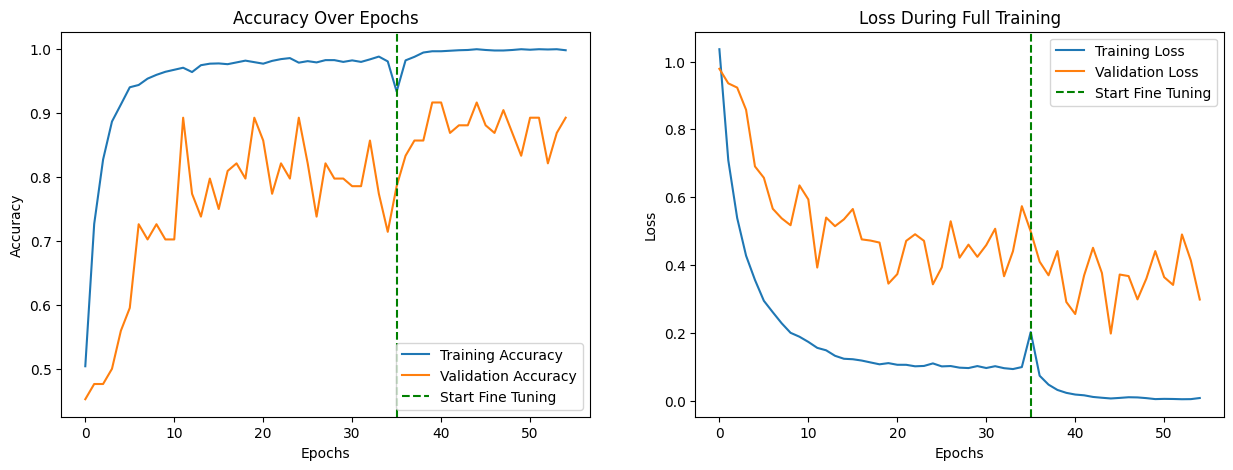

In [ ]:
plt.figure(figsize=(15, 5))

# --- Accuracy Plot ---
plt.subplot(1, 2, 1)
plt.plot(history_full_df['accuracy'], label='Training Accuracy')
plt.plot(history_full_df['val_accuracy'], label='Validation Accuracy')
plt.axvline(x=finetune_start_epoch, linestyle='--', color='green', label='Start Fine Tuning')
plt.title("Accuracy Over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

# --- Loss Plot ---
plt.subplot(1, 2, 2)
plt.plot(history_full_df['loss'], label='Training Loss')
plt.plot(history_full_df['val_loss'], label='Validation Loss')
plt.axvline(x=finetune_start_epoch, linestyle='--', color='green', label='Start Fine Tuning')
plt.title("Loss During Full Training")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.show()


In [ ]:
y_true = []
y_pred = []
for images, labels in test_dataset:
    preds = model.predict(images, verbose=0)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(preds, axis=1))

cm = confusion_matrix(y_true, y_pred)

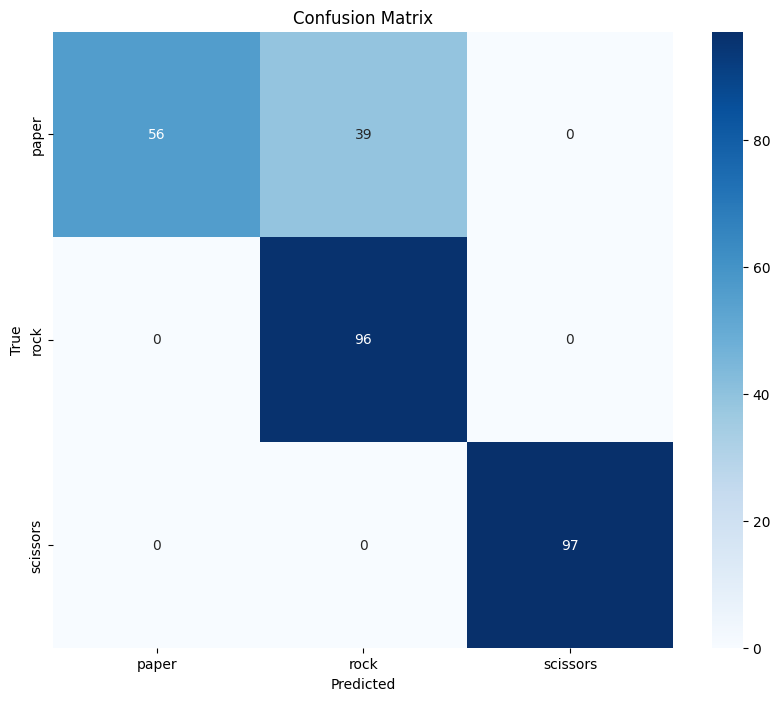

In [ ]:
# Plot
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
# Print comparison side by side
print("\nComparison:")
print(f"{'Metric':<15}{'Base Model':<15}{'Fine Tuning'}")
print(f"{'-'*40}")
print(f"{'Loss':<15}{loss1:<15.4f}{loss3:.4f}")
print(f"{'Accuracy':<15}{accuracy1:<15.4f}{accuracy3:.4f}")


Comparison:
Metric         Base Model     Fine Tuning
----------------------------------------
Loss           0.4630         0.3652
Accuracy       0.7917         0.8750


Predictions:
 [2 1 1 1 1 2 2 1 1 1 1 2 1 0 0 0 1 1 2 0 2 1 1 1 2 2 0 2 2 1 1 0]
Labels:
 [2 0 1 1 1 2 2 1 1 1 1 2 1 0 0 0 0 1 2 0 2 0 1 0 2 2 0 2 2 1 1 0]


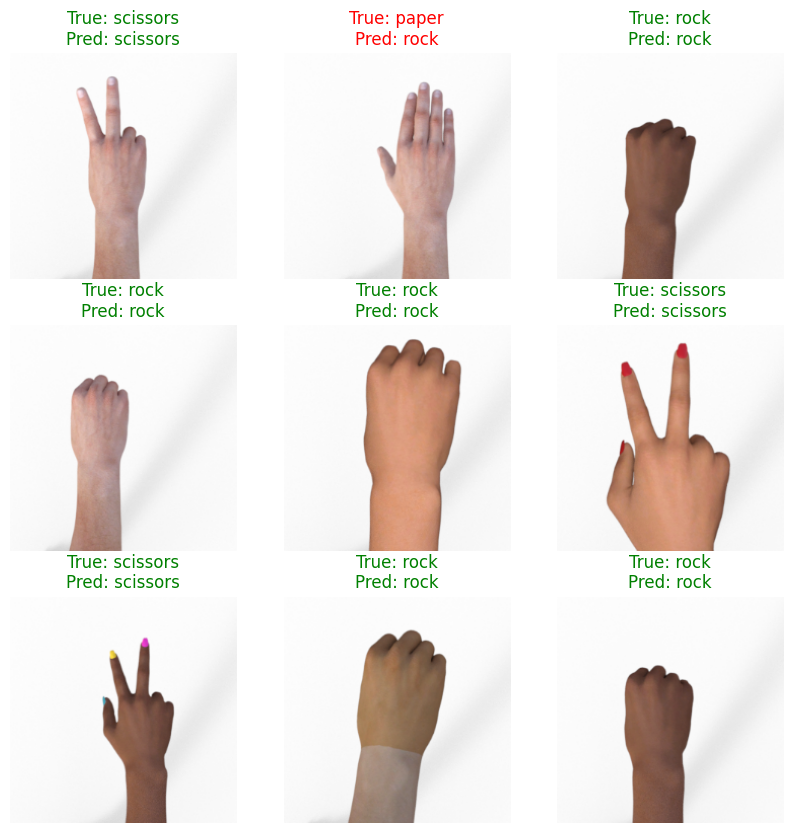

In [ ]:
# Retrieve a batch of images from the test set
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch)
predicted_classes = np.argmax(predictions, axis=1)

print('Predictions:\n', predicted_classes)
print('Labels:\n', label_batch)

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  true_label = class_names[label_batch[i]]
  predicted_label = class_names[predicted_classes[i]]
  plt.title(f"True: {true_label}\nPred: {predicted_label}", color="green" if true_label == predicted_label else "red")
  plt.axis("off")

## Loading the Pretrained Model - Xception

In [14]:
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.Xception(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [15]:
preprocess_input = tf.keras.applications.xception.preprocess_input

In [16]:
base_model.trainable = False

In [17]:
base_model.summary()

Model: "xception"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1        │ (None, 111, 111,  │        864 │ input_layer[0][0] │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1_bn     │ (None, 111, 111,  │        128 │ block1_conv1[0][… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1_act    │ (None, 111, 111,  │          0 │ block1_conv1_bn[… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2        │ (None, 109, 109,  │     18,432 │ block1_conv1_act… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2_bn     │ (None, 109, 109,  │        256 │ block1_conv2[0][… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2_act    │ (None, 109, 109,  │          0 │ block1_conv2_bn[… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv1     │ (None, 109, 109,  │      8,768 │ block1_conv2_act… │
│ (SeparableConv2D)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv1_bn  │ (None, 109, 109,  │        512 │ block2_sepconv1[… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv2_act │ (None, 109, 109,  │          0 │ block2_sepconv1_… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv2     │ (None, 109, 109,  │     17,536 │ block2_sepconv2_… │
│ (SeparableConv2D)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv2_bn  │ (None, 109, 109,  │        512 │ block2_sepconv2[… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 55, 55,    │      8,192 │ block1_conv2_act… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_pool         │ (None, 55, 55,    │          0 │ block2_sepconv2_… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 55, 55,    │        512 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 55, 55,    │          0 │ block2_pool[0][0… │
│                     │ 128)              │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_sepconv1_act │ (None, 55, 55,    │          0 │ add[0][0]       

 Total params: 20,861,480 (79.58 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 20,861,480 (79.58 MB)

## Adding custom top to the base model - Xception

In [18]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 7, 7, 2048)


In [19]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()

feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 2048)


In [20]:
prediction_layer = tf.keras.layers.Dense(3, activation='softmax')

prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 3)


In [21]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.2),
])

In [22]:
dropout_layer = tf.keras.layers.Dropout(0.2)

In [23]:
inputs = tf.keras.Input(shape=(224, 224, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = dropout_layer(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [24]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ true_divide (TrueDivide)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ subtract (Subtract)             │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ xception (Functional)           │ (None, 7, 7, 2048)     │    20,861,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 3)              │         6,147 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,867,627 (79.60 MB)

 Trainable params: 6,147 (24.01 KB)

 Non-trainable params: 20,861,480 (79.58 MB)

In [25]:
len(model.trainable_variables)

2

## Train the model - Xception

In [26]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=["accuracy"])

In [27]:
loss0, accuracy0 = model.evaluate(validation_dataset)

3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 128ms/step - accuracy: 0.3188 - loss: 1.2026


In [28]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                                                 factor=0.5,
                                                 patience=3,
                                                 min_lr=1e-6,
                                                 verbose=1)

checkpoint = tf.keras.callbacks.ModelCheckpoint('best_tuned_model.keras',
                                                monitor='val_loss',
                                                save_best_only=True,
                                                verbose=1)
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                              patience=10,
                                              restore_best_weights=True,
                                              verbose=1)

In [29]:
initial_epochs = 100

history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset,
                    callbacks=[reduce_lr,checkpoint, early_stop])

Epoch 1/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.4243 - loss: 1.0562
Epoch 1: val_loss improved from inf to 0.91753, saving model to best_tuned_model.keras
79/79 ━━━━━━━━━━━━━━━━━━━━ 9s 41ms/step - accuracy: 0.4250 - loss: 1.0556 - val_accuracy: 0.6190 - val_loss: 0.9175 - learning_rate: 1.0000e-04
Epoch 2/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.6593 - loss: 0.8777
Epoch 2: val_loss improved from 0.91753 to 0.83202, saving model to best_tuned_model.keras
79/79 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - accuracy: 0.6597 - loss: 0.8773 - val_accuracy: 0.6905 - val_loss: 0.8320 - learning_rate: 1.0000e-04
Epoch 3/100
77/79 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.7971 - loss: 0.7521
Epoch 3: val_loss improved from 0.83202 to 0.77413, saving model to best_tuned_model.keras
79/79 ━━━━━━━━━━━━━━━━━━━━ 3s 37ms/step - accuracy: 0.7975 - loss: 0.7511 - val_accuracy: 0.5952 - val_loss: 0.7741 - learning_rate: 1.0000e-04
Epoch 4/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s

In [30]:
loss1, accuracy1 = model.evaluate(test_dataset)
loss2, accuracy2 = model.evaluate(train_dataset)
print('Test loss :', loss1)
print('Train loss :', loss2)
print('Test accuracy :', accuracy1)
print('Train accuracy :', accuracy2)

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.5643 - loss: 0.7727
79/79 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - accuracy: 0.9114 - loss: 0.3650
Test loss : 0.80531907081604
Train loss : 0.3614411950111389
Test accuracy : 0.5659722089767456
Train accuracy : 0.9119047522544861


In [31]:
history_df = pd.DataFrame(history.history)

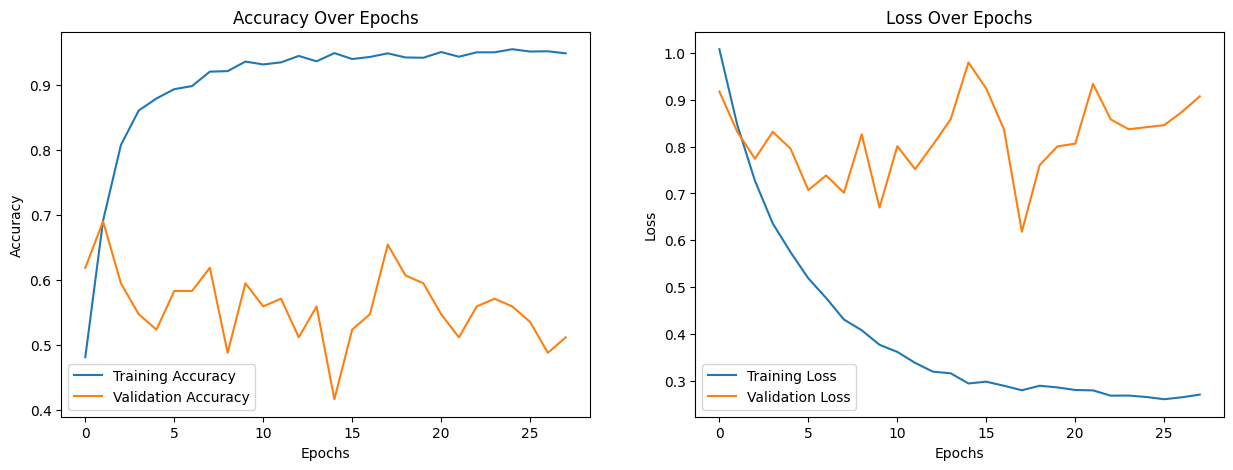

In [32]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(history_df['accuracy'], label='Training Accuracy')
plt.plot(history_df['val_accuracy'], label='Validation Accuracy')
plt.title("Accuracy Over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_df['loss'], label='Training Loss')
plt.plot(history_df['val_loss'], label='Validation Loss')
plt.title("Loss Over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [33]:
from sklearn.metrics import confusion_matrix

y_true = []
y_pred = []
for images, labels in test_dataset:
    preds = model.predict(images, verbose=0)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(preds, axis=1))

cm = confusion_matrix(y_true, y_pred)

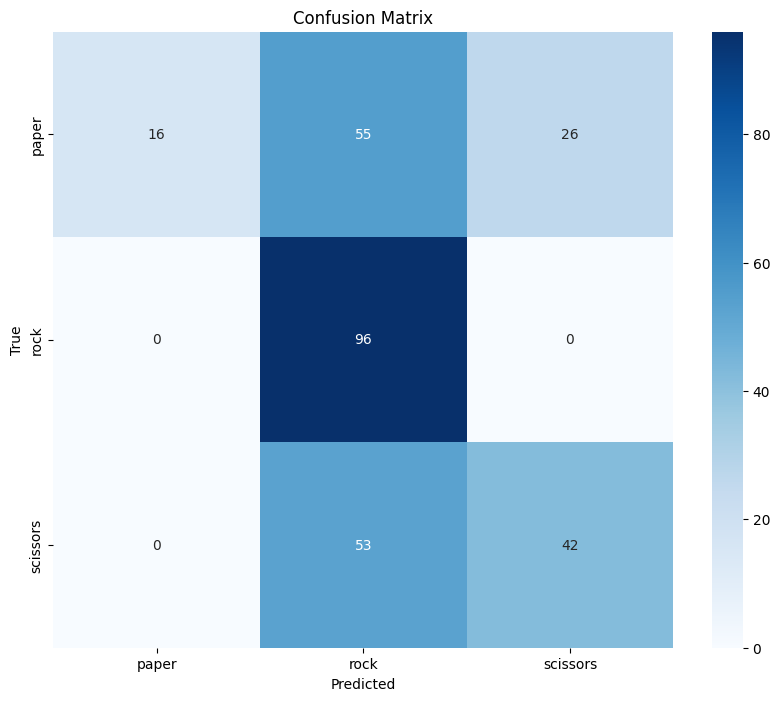

In [34]:
# Plot
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Fine Tuning the Model - Xception

In [35]:
print("Number of layers in the base model: ", len(base_model.layers))

Number of layers in the base model:  132


In [36]:
base_model.trainable = True

In [37]:
fine_tune_at = 100

for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

In [38]:
len(model.trainable_variables)

41

In [39]:
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              optimizer = tf.keras.optimizers.Adam(learning_rate=base_learning_rate/10),
              metrics=["accuracy"])

In [40]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ true_divide (TrueDivide)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ subtract (Subtract)             │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ xception (Functional)           │ (None, 7, 7, 2048)     │    20,861,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 3)              │         6,147 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,867,627 (79.60 MB)

 Trainable params: 9,484,491 (36.18 MB)

 Non-trainable params: 11,383,136 (43.42 MB)

In [41]:
fine_tune_epochs = 100
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=len(history.epoch),
                         validation_data=validation_dataset,
                         callbacks=[reduce_lr,checkpoint, early_stop])

Epoch 29/200
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 0.8857 - loss: 0.4494
Epoch 29: val_loss did not improve from 0.61824
79/79 ━━━━━━━━━━━━━━━━━━━━ 18s 77ms/step - accuracy: 0.8862 - loss: 0.4482 - val_accuracy: 0.5238 - val_loss: 1.6388 - learning_rate: 1.0000e-05
Epoch 30/200
78/79 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9757 - loss: 0.1532
Epoch 30: val_loss did not improve from 0.61824
79/79 ━━━━━━━━━━━━━━━━━━━━ 4s 48ms/step - accuracy: 0.9758 - loss: 0.1526 - val_accuracy: 0.5833 - val_loss: 1.4734 - learning_rate: 1.0000e-05
Epoch 31/200
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.9898 - loss: 0.0776
Epoch 31: val_loss did not improve from 0.61824
79/79 ━━━━━━━━━━━━━━━━━━━━ 4s 47ms/step - accuracy: 0.9898 - loss: 0.0775 - val_accuracy: 0.7143 - val_loss: 0.9910 - learning_rate: 1.0000e-05
Epoch 32/200
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.9944 - loss: 0.0519
Epoch 32: val_loss improved from 0.61824 to 0.60274, saving model to best_t

In [42]:
loss3, accuracy3 = model.evaluate(test_dataset)
loss4, accuracy4 = model.evaluate(train_dataset)
print('Test loss :', loss3)
print('Train loss :', loss4)
print('Test accuracy :', accuracy3)
print('Train accuracy :', accuracy4)

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.8540 - loss: 0.3874
79/79 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - accuracy: 1.0000 - loss: 0.0014
Test loss : 0.37538447976112366
Train loss : 0.0013951165601611137
Test accuracy : 0.8611111044883728
Train accuracy : 1.0


In [43]:
history_fine_df = pd.DataFrame(history_fine.history)
history_fine_df.index += len(history_df)

In [44]:
history_full_df = pd.concat([history_df, history_fine_df])

In [45]:
finetune_start_epoch = len(history_df)

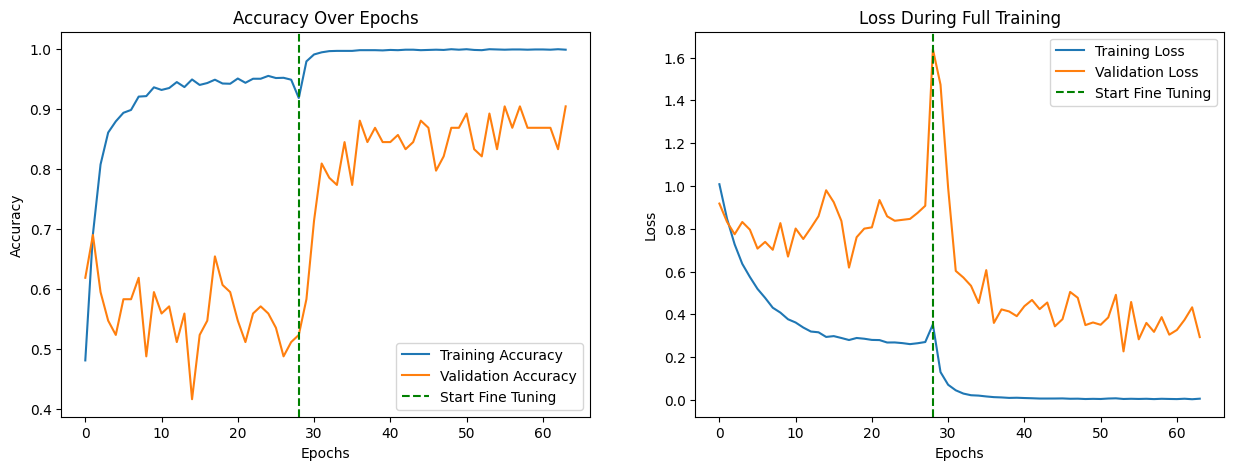

In [46]:
plt.figure(figsize=(15, 5))

# --- Accuracy Plot ---
plt.subplot(1, 2, 1)
plt.plot(history_full_df['accuracy'], label='Training Accuracy')
plt.plot(history_full_df['val_accuracy'], label='Validation Accuracy')
plt.axvline(x=finetune_start_epoch, linestyle='--', color='green', label='Start Fine Tuning')
plt.title("Accuracy Over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

# --- Loss Plot ---
plt.subplot(1, 2, 2)
plt.plot(history_full_df['loss'], label='Training Loss')
plt.plot(history_full_df['val_loss'], label='Validation Loss')
plt.axvline(x=finetune_start_epoch, linestyle='--', color='green', label='Start Fine Tuning')
plt.title("Loss During Full Training")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.show()


In [47]:
y_true = []
y_pred = []
for images, labels in test_dataset:
    preds = model.predict(images, verbose=0)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(preds, axis=1))

cm = confusion_matrix(y_true, y_pred)

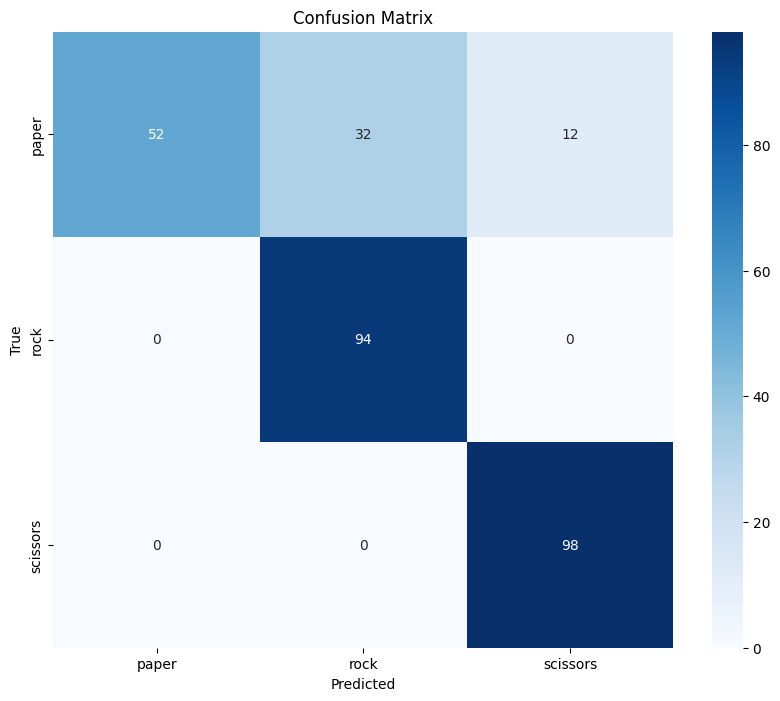

In [48]:
# Plot
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [49]:
# Print comparison side by side
print("\nComparison:")
print(f"{'Metric':<15}{'Base Model':<15}{'Fine Tuning'}")
print(f"{'-'*40}")
print(f"{'Loss':<15}{loss1:<15.4f}{loss3:.4f}")
print(f"{'Accuracy':<15}{accuracy1:<15.4f}{accuracy3:.4f}")


Comparison:
Metric         Base Model     Fine Tuning
----------------------------------------
Loss           0.8053         0.3754
Accuracy       0.5660         0.8611


Predictions:
 [0 2 1 0 1 1 1 0 1 1 1 0 1 1 1 2 2 2 2 2 0 2 2 1 1 1 2 1 1 2 1 2]
Labels:
 [0 0 1 0 1 1 0 0 1 0 1 0 1 0 1 2 2 2 2 2 0 2 2 0 1 1 2 1 1 0 1 2]


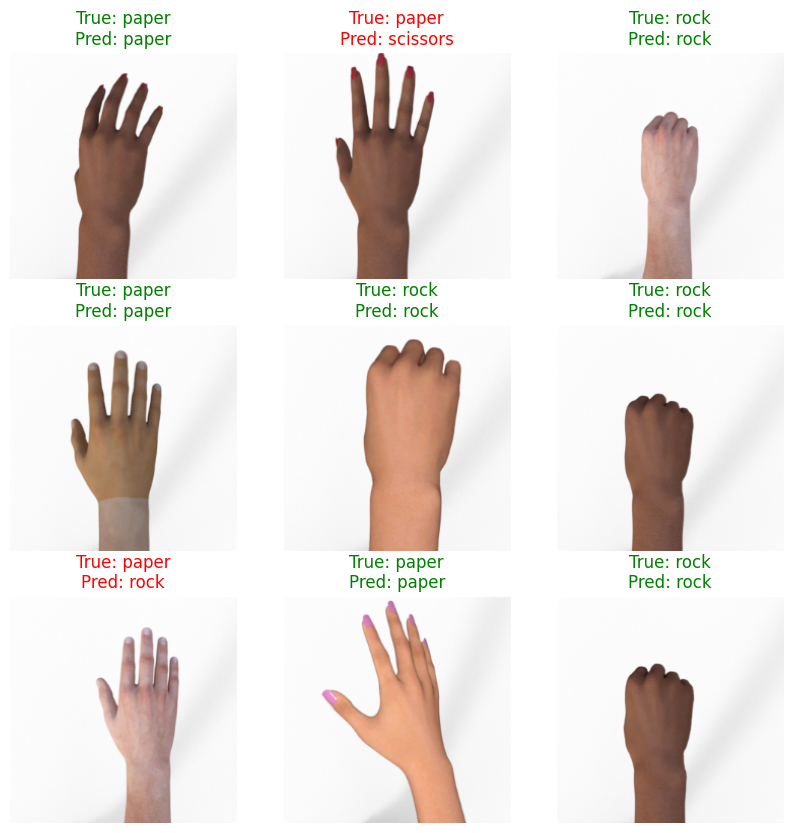

In [50]:
# Retrieve a batch of images from the test set
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch)
predicted_classes = np.argmax(predictions, axis=1)

print('Predictions:\n', predicted_classes)
print('Labels:\n', label_batch)

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  true_label = class_names[label_batch[i]]
  predicted_label = class_names[predicted_classes[i]]
  plt.title(f"True: {true_label}\nPred: {predicted_label}", color="green" if true_label == predicted_label else "red")
  plt.axis("off")

# Summary

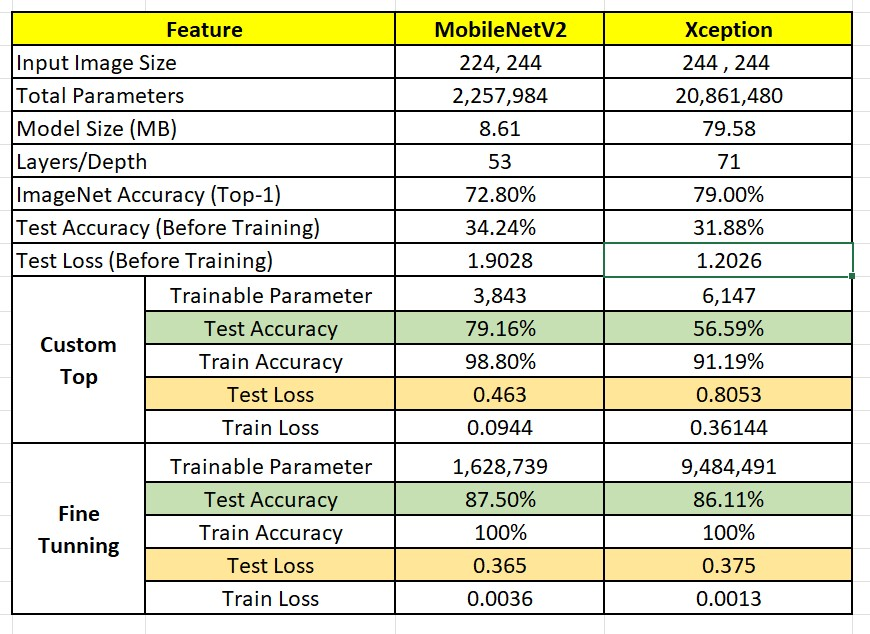

It is evident from above table that MobilenetV2 pretrained model with fine tunning works slightly better than Xception both interms of accuracy and loss, also trainable parameters of Mobilenetv2 are 5 times less than Xception model.